In [62]:
import numpy
import matplotlib.pyplot as plt

## Problem 1

Wrote a new 1D solver. I had two issues intially, I didn't change `MatSetVecStencil` to `MatSetValues` and I had a sign error in the b vector. I had to look up the issue with the solution.

In [1]:
!for K in 0 1 2 3 4 5 6; do ./poisson1D -da_refine $K; done

on 9 grid:  error |u-uexact|_inf = 0.00390625
on 17 grid:  error |u-uexact|_inf = 0.000976563
on 33 grid:  error |u-uexact|_inf = 0.000244141
on 65 grid:  error |u-uexact|_inf = 6.10352e-05
on 129 grid:  error |u-uexact|_inf = 1.52588e-05
on 257 grid:  error |u-uexact|_inf = 3.8147e-06
on 513 grid:  error |u-uexact|_inf = 9.53674e-07


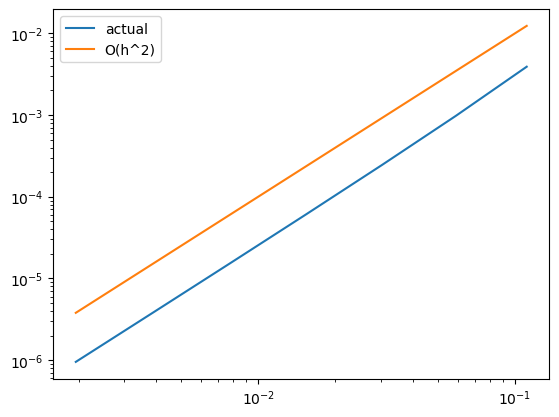

In [4]:
import numpy as np
import matplotlib.pyplot as plt


N = np.array([9, 17, 33, 65, 129, 257, 513], dtype=float)
error = np.array([0.00390625, 0.000976563, 0.000244141, 6.10352e-5, 1.52588e-05, 3.8147e-06, 9.53674e-07])
h = 1. / N

plt.loglog(h, error, label='actual')
plt.loglog(h, h**2, label='O(h^2)')
plt.legend()

In [22]:
!./poisson1D -da_refine 15 -ksp_rtol 1.0e-13

on 262145 grid:  error |u-uexact|_inf = 3.84406e-12


Needs to be refined 15 times to reach desired accuracy (11 sig figs)

## Problem 2

In [23]:
!for K in 0 1 2 3 4 5 6; do ./poisson_modify -da_refine $K -ksp_rtol 1.0e-13; done

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.
on 9 x 9 grid:  error |u-uexact|_inf = 1.8735e-16
on 17 x 17 grid:  error |u-uexact|_inf = 9.71445e-16
on 33 x 33 grid:  error |u-uexact|_inf = 4.85029e-15
on 65 x 65 grid:  error |u-uexact|_inf = 2.66454e-15
on 129 x 129 grid:  error |u-uexact|_inf = 4.89192e-15
on 257 x 257 grid:  error |u-uexact|_inf = 7.52176e-15
on 513 x 513 grid:  error |u-uexact|_inf = 6.74114e-14


Totally accuracy from the first grid

Another way to think about this is in terms of a flux in a FV schema. The approximated flux is perfectly approximated when the solution is at the exact solution (as the flux is only linearly dependent on the spatial position so the difference gives the exact flux). The solution will natuarlly converge to the exact solution quickly.

e.g. if $u = x^2$

$((x + dx)^2 - (x - dx)^2) / 2 / dx$ which equals $2 x$

In [25]:
!./poisson_modify -ksp_rtol 1.0e-13 -ksp_monitor

  0 KSP Residual norm 1.029622842940e-01 
  1 KSP Residual norm 1.703672925481e-02 
  2 KSP Residual norm 2.237035700617e-03 
  3 KSP Residual norm 2.448470217722e-04 
  4 KSP Residual norm 2.464643527576e-05 
  5 KSP Residual norm 5.355098945648e-06 
  6 KSP Residual norm 4.916669726533e-07 
  7 KSP Residual norm 4.288476133651e-08 
  8 KSP Residual norm 3.692323124120e-09 
  9 KSP Residual norm 2.104937129225e-10 
 10 KSP Residual norm 2.384259671169e-11 
 11 KSP Residual norm 2.078027469864e-12 
 12 KSP Residual norm 1.100253927462e-13 
 13 KSP Residual norm 1.032007747618e-14 
 14 KSP Residual norm 4.430080957291e-16 
on 9 x 9 grid:  error |u-uexact|_inf = 1.8735e-16


## Problem 3

Works, here's the main loop that changes (also exact solution changed on one line).

```c
    for (j=info.ys; j<info.ys+info.ym; j++) {
        y = j * hy;
        for (i=info.xs; i<info.xs+info.xm; i++) {
            x = i * hx;
            if (i==0 || i==info.mx-1 || j==0 || j==info.my-1) {
	      u = 3.0 * x + sin(20.0 * x * y);
	      ab[j][i] = u;  // on boundary: 1*u = 0
            } else {
	      f = 400.0 * (x * x + y * y) * sin(20.0 * x * y);
	      ab[j][i] = hx * hy * f;

	      if (i == 1) {
		x_ = x - hx;
		y_ = y;
		u = 3.0 * x_ + sin(20.0 * x_ * y_);
		ab[j][i] = ab[j][i] + hy * u / hx;		
	      }
	      if (i == info.mx - 2) {
		x_ = x + hx;
		y_ = y;
		u = 3.0 * x_ + sin(20.0 * x_ * y_);
		ab[j][i] = ab[j][i] + hy * u / hx;		
	      }
	      if (j == 1) {
		x_ = x;
		y_ = y - hy;
		u = 3.0 * x_ + sin(20.0 * x_ * y_);
		ab[j][i] = ab[j][i] + hx * u / hy;
	      }
	      if (j == info.my - 2) {
		x_ = x;
		y_ = y + hy;
		u = 3.0 * x_ + sin(20.0 * x_ * y_);
		ab[j][i] = ab[j][i] + hx * u / hy;
	      }
            }
    
        }
    }

```

and here are the numbers for 

```
(nix)[wd15@pippi:~/git/p4pdes/c/ch3](wd15)$ for K in 0 1 2 3 4 5; do ./poisson_dirichlet -da_refine $K -ksp_rtol 1.0e-13; done
on 9 x 9 grid:  error |u-uexact|_inf = 0.449932
on 17 x 17 grid:  error |u-uexact|_inf = 0.118471
on 33 x 33 grid:  error |u-uexact|_inf = 0.0279736
on 65 x 65 grid:  error |u-uexact|_inf = 0.00686974
on 129 x 129 grid:  error |u-uexact|_inf = 0.00170982
on 257 x 257 grid:  error |u-uexact|_inf = 0.000427765
```

looks good!

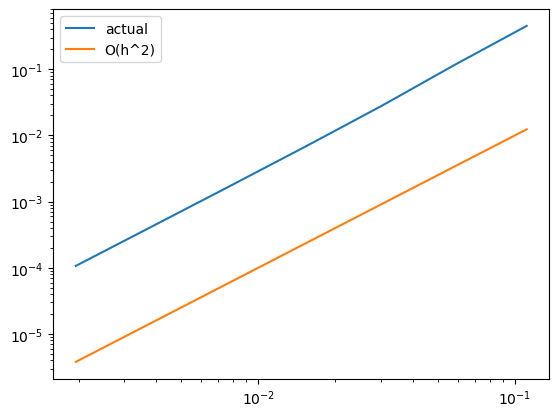

In [29]:
import numpy as np
import matplotlib.pyplot as plt


N = np.array([9, 17, 33, 65, 129, 257, 513], dtype=float)
error = np.array([0.449932, 0.118471, 0.0279736, 0.00686974, 0.00170982, 0.000427765,0.000106915])
h = 1. / N

plt.loglog(h, error, label='actual')
plt.loglog(h, h**2, label='O(h^2)')
plt.legend()

## Problem 4

The matrix has already been scaled and the diagonal doesn't vary very much.


## Problem 5

Event counts:

```
Event              Count

BuildTwoSided          1 1.0 1.3379e-05 1.0 0.00e+00 0.0 0.0e+00 0.0e+00 0.0e+00  0  0  0  0  0   0  0  0  0  0     0
DMCreateMat            1 1.0 2.8362e-04 1.0 0.00e+00 0.0 0.0e+00 0.0e+00 0.0e+00  5  0  0  0  0   5  0  0  0  0     0
SFSetGraph             1 1.0 1.2699e-05 1.0 0.00e+00 0.0 0.0e+00 0.0e+00 0.0e+00  0  0  0  0  0   0  0  0  0  0     0
SFSetUp                1 1.0 5.8771e-05 1.0 0.00e+00 0.0 0.0e+00 0.0e+00 0.0e+00  1  0  0  0  0   1  0  0  0  0     0
VecTDot               36 1.0 2.4509e-05 1.0 5.80e+03 1.0 0.0e+00 0.0e+00 0.0e+00  0 21  0  0  0   0 21  0  0  0   236
VecNorm               19 1.0 1.7940e-05 1.0 2.90e+03 1.0 0.0e+00 0.0e+00 0.0e+00  0 10  0  0  0   0 10  0  0  0   162
VecCopy               20 1.0 1.4083e-05 1.0 0.00e+00 0.0 0.0e+00 0.0e+00 0.0e+00  0  0  0  0  0   0  0  0  0  0     0
VecSet                 1 1.0 3.0280e-06 1.0 0.00e+00 0.0 0.0e+00 0.0e+00 0.0e+00  0  0  0  0  0   0  0  0  0  0     0
VecAXPY               35 1.0 2.3378e-05 1.0 5.67e+03 1.0 0.0e+00 0.0e+00 0.0e+00  0 20  0  0  0   0 20  0  0  0   243
VecAYPX               16 1.0 1.1095e-05 1.0 2.59e+03 1.0 0.0e+00 0.0e+00 0.0e+00  0  9  0  0  0   0  9  0  0  0   234
MatMult               17 1.0 3.4434e-05 1.0 1.12e+04 1.0 0.0e+00 0.0e+00 0.0e+00  1 40  0  0  0   1 40  0  0  0   324
MatAssemblyBegin       2 1.0 1.5110e-06 1.0 0.00e+00 0.0 0.0e+00 0.0e+00 0.0e+00  0  0  0  0  0   0  0  0  0  0     0
MatAssemblyEnd         2 1.0 1.8849e-05 1.0 0.00e+00 0.0 0.0e+00 0.0e+00 0.0e+00  0  0  0  0  0   0  0  0  0  0     0
KSPSetUp               1 1.0 5.9443e-05 1.0 0.00e+00 0.0 0.0e+00 0.0e+00 0.0e+00  1  0  0  0  0   1  0  0  0  0     0
KSPSolve               1 1.0 4.4243e-04 1.0 2.80e+04 1.0 0.0e+00 0.0e+00 0.0e+00  8 99  0  0  0   8 99  0  0  0    63
PCSetUp                1 1.0 5.7300e-07 1.0 0.00e+00 0.0 0.0e+00 0.0e+00 0.0e+00  0  0  0  0  0   0  0  0  0  0     0
PCApply               18 1.0 2.1939e-05 1.0 0.00e+00 0.0 0.0e+00 0.0e+00 0.0e+00  0  0  0  0  0   0  0  0  0  0     0
```

Iteration count

```
Linear solve converged due to CONVERGED_RTOL iterations 17
on 9 x 9 grid:  error |u-uexact|_inf = 0.00076388
```

17 `MatMult` is correct. 36 `VecTDot` is correct, but 35 `VecAXPY` and 16 `VecAYPX`? One less on those then we should have. This makes sense since there are two operations after the `return` statement in Problem 2.8. Those two operations are prepeartion for the next interation so aren't required.



## Problem 6

(i) Show that $||\vec{v}||_A = \sqrt{\vec{v}^T A \vec{v}}$ is a vector norm if $A$ is SPD

To be a vector norm must satisfy the positivitiy rule, the scaling rule and triangle inequality

positivity is trivial: $||\vec{0}||_A = \sqrt{\vec{0}^T A \vec{0}}=0$ for any matrix

scaling rule also trivial: $||k \vec{v}||_A = \sqrt{\left(k \vec{v}\right)^T A \left( k \vec{v} \right)} = |k| ||\vec{v}||_A $ since 
$\left(k \vec{v}\right)^T=|k| \vec{v}^T$. True for any matrix.

triangle inequality:

\begin{align}
||\vec{u} + \vec{v}||_A =& \sqrt{\left(\vec{u} + \vec{v}\right)^T A \left(\vec{u} + \vec{v}\right)} \\
                        =& \sqrt{\left(\vec{u}^T + \vec{v}^T\right) A \left(\vec{u} + \vec{v}\right)} \\
                        =& \sqrt{\vec{u}^T A \vec{u} + \vec{v}^T A \vec{v} + \vec{u}^T A \vec{v} + \vec{v}^T A \vec{u}} \\     
                        =& \sqrt{||\vec{u}||_A^2 + ||\vec{v}||_A^2 + 2 \vec{v}^T A \vec{u} } \\
                        \le &  \sqrt{||\vec{u}||_A^2 + ||\vec{v}||_A^2 + 2 | \vec{v}^T A \vec{u} |} \\
                        \le & \sqrt{||\vec{u}||_A^2 + ||\vec{v}||_A^2 + 2 ||\vec{v}||_A ||\vec{u}||_A } \;\; \text{from Cauchy-Schwarz inequality} \\
                        =& \sqrt{\left(||\vec{u}||_A^2 + ||\vec{v}||_A^2\right)^2  } \\ 
\end{align}


(ii) 

\begin{align}
||v||_A = v^T A v =& v^T \left(\sqrt{A} \right)^2 v \\
                  =& v^T \sqrt{A} \sqrt{A}  v \\
                  =& \sqrt{A}^T v \sqrt{A} v \\
                  =& \sqrt{A} v \sqrt{A} v \\
                  =& ||\sqrt{A} v ||_2
\end{align}

Notice that $\sqrt{A} = S \Lambda S^{-1} $. Therefore, $A = S \Lambda^2 S^{-1}$. Likewise for their inverses since, $ \left(\sqrt{A}\right)^{-1} \left(\sqrt{A}\right)^{-1} = A^{-1}$

Now we know that $\kappa_2\left(\sqrt{A}\right) = \frac{\max{\Lambda}}{\min{\Lambda}}= 
\sqrt{\left(\frac{\max{\Lambda}}{\min{\Lambda}}\right)^2}=\sqrt{\kappa\left(A\right)}$ 

(iii)

\begin{align}
A e =& - r \\
||A e ||_2 =& ||r||_2 \\
|| r ||_2 =& || \sqrt{A} \sqrt{A} e ||_2 \\
|| r ||_2 \le& || \sqrt{A} ||_2 || e ||_A \\
\frac{||r||_2}{|| \sqrt{A} ||_2} \le& ||e||_A 
\end{align}

\begin{align}
e =& - A^{-1} r \\
||e ||_A =& ||A^{-1} r||_2 \\
|| e ||_A =& || \sqrt{A} A^{-1} r ||_2 \\
|| e ||_A =& || \sqrt{A}^{-1} r ||_2 \\
||e||_A \le& || \sqrt{A}^{-1} ||_2 ||r||_2 
\end{align}



(iv) 

To show this we must show that

\begin{align}
\frac{||r_j||_2}{||r_0||_2} \le& \sqrt{\kappa} \frac{||e_j||_2}{||e_0||_2} \\
\end{align}

So,

\begin{align}
\frac{||e_j||_2}{||e_0||_2} \ge& \frac{||r_j||_2}{||e_0||_A || \sqrt{A} ||_2} \\
\frac{||e_j||_2}{||e_0||_2} \ge& \frac{||r_j||_2}{||r_0||_A || \sqrt{A} ||_2 || \sqrt{A}^{-1} ||_2}
\;\; \text{using inequalites from above} \\
\frac{||e_j||_2}{||e_0||_2} \ge& \frac{||r_j||_2}{||r_0||_A \kappa\left(\sqrt{A}\right) } \\
\sqrt{\kappa} \frac{||e_j||_2}{||e_0||_2} \ge& \frac{||r_j||_2}{||r_0||_A} \\
\end{align}

## Problem 7

Regenerate Figure 3.11, which is the figure of the eigenvalues versus h when solving poisson in 2D. Note that to get it to look like the image in the text it's better to use `-ksp_type cg` rather than `-ksp_type gmres` as it produces more eigenvalues, see [this](https://epubs.siam.org/doi/epdf/10.1137/1.9781611976311.ch3).

In [96]:
def get_eigenvalues(nx):
    N = nx + 1
    h = 1. / nx
    datafile = "data.txt"
    !./poisson_dirichlet -pc_type none -ksp_view_eigenvalues -da_grid_x $N -da_grid_y $N -ksp_type cg > $datafile
    wc_out = !wc -l < $datafile
    number_of_lines = int(wc_out[0]) - 2
    data = (numpy.ones(number_of_lines) * h,
            numpy.loadtxt(datafile, skiprows=1, usecols=0, delimiter=" ", max_rows=number_of_lines) / h**2)
    !rm $datafile
    return data


In [104]:
nxs = [4, 8, 16, 32, 64, 128]
data = [get_eigenvalues(x) for x in nxs]

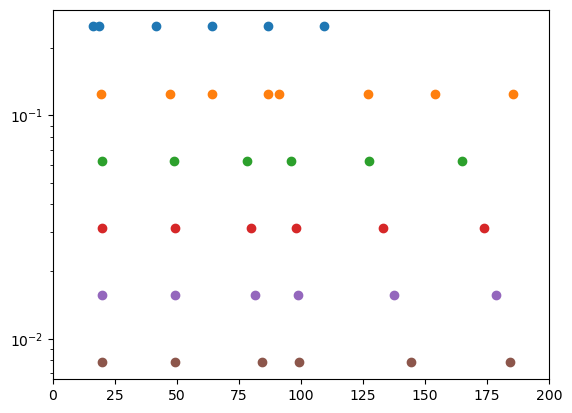

In [106]:
fig, ax = plt.subplots()
[plt.scatter(y, x) for (x, y) in data]
plt.xlim((0, 200))
ax.set_yscale("log")
ygrid = 1. / numpy.array(nxs)

## Problem 8

This is a little confusing as MINRES is actually in the table and the iteration count is a bit different from CG.
With icc precon the interation counts are very similar. Not sure what the point is here.

In [108]:
!./poisson -pc_type icc -da_grid_x 257 -da_grid_y 257 -ksp_type cg -ksp_converged_reason

Linear solve converged due to CONVERGED_RTOL iterations 177
on 257 x 257 grid:  error |u-uexact|_inf = 7.82448e-07


In [109]:
!./poisson -pc_type icc -da_grid_x 257 -da_grid_y 257 -ksp_type minres -ksp_converged_reason

Linear solve converged due to CONVERGED_RTOL iterations 174
on 257 x 257 grid:  error |u-uexact|_inf = 7.7987e-07


In [110]:
!./poisson -pc_type none -da_grid_x 257 -da_grid_y 257 -ksp_type cg -ksp_converged_reason

Linear solve converged due to CONVERGED_RTOL iterations 606
on 257 x 257 grid:  error |u-uexact|_inf = 7.69971e-07


In [111]:
!./poisson -pc_type none -da_grid_x 257 -da_grid_y 257 -ksp_type minres -ksp_converged_reason

Linear solve converged due to CONVERGED_RTOL iterations 579
on 257 x 257 grid:  error |u-uexact|_inf = 7.77577e-07


In [113]:
!./poisson -pc_type jacobi -da_grid_x 257 -da_grid_y 257 -ksp_type cg -ksp_converged_reason

Linear solve converged due to CONVERGED_RTOL iterations 606
on 257 x 257 grid:  error |u-uexact|_inf = 7.69971e-07


In [114]:
!./poisson -pc_type jacobi -da_grid_x 257 -da_grid_y 257 -ksp_type minres -ksp_converged_reason

Linear solve converged due to CONVERGED_RTOL iterations 579
on 257 x 257 grid:  error |u-uexact|_inf = 7.77577e-07


## Problem 9

Show that iterations increase for both GMRES + ILU and MINRES + ICC, just like for CG + ICC (Figure 3.12 in the text)

GMRES iteration count seems to scale even worse. Shows similar results to Problem 8 for CG and MINRES.

In [146]:
def get_iterations(nx, ksp_type, pc_type):
    filename = 'data.txt'
    !./poisson -pc_type $pc_type -da_grid_x $nx -da_grid_y $nx -ksp_type $ksp_type -ksp_converged_reason > $filename
    tmp = !cat $filename | head -1
    value = int(tmp[0].split(" ")[-1])
    return value

In [147]:
nxs = numpy.array([17, 33, 65, 129, 257])
combos = [('cg', 'icc'), ('minres', 'icc'), ('gmres', 'ilu'), ('cg', 'none')]

In [148]:

data = [[get_iterations(nx, ksp_type, pc_type) for nx in nxs] for (ksp_type, pc_type) in combos] 

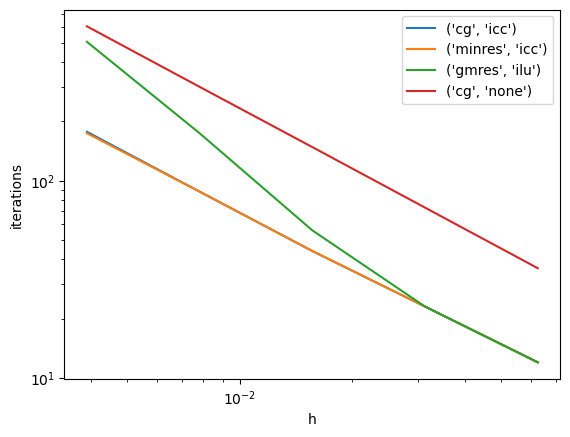

In [149]:
for i, combo in enumerate(combos):
    plt.loglog(1 / (nxs - 1), data[i], label=combo)
plt.ylabel("iterations")
plt.xlabel("h")
plt.legend()

## Problem 10

I'm assuming this is mg preconditioning which doesn't impact the actual solver at all. The solver will still take a lot of iterations as the size of the matrix does not change with only multigrid preconditioning.

In [151]:
!./poisson -da_refine 7 -ksp_type cg -pc_type mg

on 1025 x 1025 grid:  error |u-uexact|_inf = 5.33244e-08


In [152]:
!./poisson -da_refine 7 -ksp_type cg -pc_type mg -ksp_view

KSP Object: 1 MPI process
  type: cg
  maximum iterations=10000, initial guess is zero
  tolerances:  relative=1e-05, absolute=1e-50, divergence=10000.
  left preconditioning
  using PRECONDITIONED norm type for convergence test
PC Object: 1 MPI process
  type: mg
    type is MULTIPLICATIVE, levels=1 cycles=v
      Cycles per PCApply=1
      Not using Galerkin computed coarse grid matrices
  Coarse grid solver -- level 0 -------------------------------
    KSP Object: (mg_levels_0_) 1 MPI process
      type: chebyshev
        Chebyshev polynomial of first kind
        eigenvalue targets used: min 0.0995821, max 1.0954
        eigenvalues estimated via gmres: min 0.0130144, max 0.995821
        eigenvalues estimated using gmres with transform: [0. 0.1; 0. 1.1]
        KSP Object: (mg_levels_0_esteig_) 1 MPI process
          type: gmres
            restart=30, using Classical (unmodified) Gram-Schmidt Orthogonalization with no iterative refinement
            happy breakdown tolerance 1

## Problem 11

Not doing this as can't change debugging status

## Problem 12

Seems to work

In [154]:
!./poisson3D -ksp_type cg -pc_type icc -ksp_converged_reason -da_refine 2 -ksp_view

Linear solve converged due to CONVERGED_RTOL iterations 28
KSP Object: 1 MPI process
  type: cg
  maximum iterations=10000, initial guess is zero
  tolerances:  relative=1e-05, absolute=1e-50, divergence=10000.
  left preconditioning
  using PRECONDITIONED norm type for convergence test
PC Object: 1 MPI process
  type: icc
    out-of-place factorization
    0 levels of fill
    tolerance for zero pivot 2.22045e-14
    using Manteuffel shift [POSITIVE_DEFINITE]
    matrix ordering: natural
    factor fill ratio given 1., needed 1.
      Factored matrix follows:
        Mat Object: 1 MPI process
          type: seqsbaij
          rows=35937, cols=35937
          package used to perform factorization: petsc
          total: nonzeros=140481, allocated nonzeros=140481
              block size is 1
  linear system matrix = precond matrix:
  Mat Object: 1 MPI process
    type: seqaij
    rows=35937, cols=35937
    total: nonzeros=245025, allocated nonzeros=245025
    total number of mallocs u